## Examination and Prediction of Energy consumption in Buildings
This notebook examines the energy consumption in different buildings and also attemtp to predict the future energy consumptions for some testing data.

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import xgboost as xgb

In [3]:
root= os.getcwd()
train_df = pd.read_csv(root+'/energy-prediction/train.csv')
weather_train_df = pd.read_csv(root+'/energy-prediction/weather_train.csv')

In [4]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [5]:
train_df.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [6]:
train_df['timestamp'] = train_df['timestamp'].astype('datetime64[ns]')

In [7]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [9]:
weather_train_df['timestamp'] = weather_train_df['timestamp'].astype('datetime64[ns]')
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [10]:
test_df = pd.read_csv(root+'/energy-prediction/test.csv')
weather_test_df = pd.read_csv(root+'/energy-prediction/weather_test.csv')

In [11]:
test_df['timestamp'] = test_df['timestamp'].astype('datetime64[ns]')
weather_test_df['timestamp'] = weather_test_df['timestamp'].astype('datetime64[ns]')

In [12]:
bld_data_df = pd.read_csv(root+'/energy-prediction/building_metadata.csv')

In [13]:
bld_data_df.head(2)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN


In [14]:
bld_data_df.dtypes

site_id          int64
building_id      int64
primary_use     object
square_feet      int64
year_built     float64
floor_count    float64
dtype: object

In [15]:
train_data_df = train_df.merge(bld_data_df, on='building_id', how='left')
train_data_df = train_data_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

In [16]:
train_data_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

In [23]:
train_data_df.isnull().count()

building_id           20216100
meter                 20216100
timestamp             20216100
meter_reading         20216100
site_id               20216100
primary_use           20216100
square_feet           20216100
year_built            20216100
floor_count           20216100
air_temperature       20216100
cloud_coverage        20216100
dew_temperature       20216100
precip_depth_1_hr     20216100
sea_level_pressure    20216100
wind_direction        20216100
wind_speed            20216100
dtype: int64

In [25]:
train_data_df[train_data_df['year_built'].isnull()].shape

(12127645, 16)

In [26]:
train_data_df.shape

(20216100, 16)

In [27]:
train_data_df.isnull().sum()/train_data_df.isnull().count()*100

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.990033
floor_count           82.652772
air_temperature        0.478124
cloud_coverage        43.655131
dew_temperature        0.495348
precip_depth_1_hr     18.544739
sea_level_pressure     6.092515
wind_direction         7.167792
wind_speed             0.710701
dtype: float64

In [31]:
pd.concat([train_data_df.isnull().sum(),train_data_df.isnull().sum()/train_data_df.isnull().count()*100],axis=1, keys = ['Total Missing','Percent'])

,Total Missing,Percent
building_id,0,0.000000
meter,0,0.000000
timestamp,0,0.000000
meter_reading,0,0.000000
site_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000
year_built,12127645,59.990033
floor_count,16709167,82.652772
air_temperature,96658,0.478124


In [32]:
mean_meter_reading =  train_data_df.groupby('timestamp')['meter_reading'].mean()

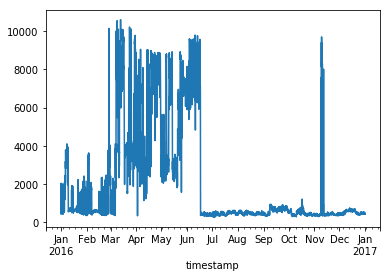

In [33]:
mean_meter_reading.plot()

In [21]:
train_data_df.head(3)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [28]:
train_data_df.head(3)

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
3021,565,0,2016-01-01 01:00:00,4,Education,15326,1954.0,2.0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1
3022,566,0,2016-01-01 01:00:00,4,Education,2010,1957.0,1.0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1
3023,569,0,2016-01-01 01:00:00,4,Education,86091,1964.0,8.0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1


In [24]:
train_data_df[train_data_df['year_built'].isnull()].shape

(12127645, 16)

In [21]:
train_data_df['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [76]:
primary_use_agg = train_data_df.groupby(['primary_use']).agg(['size','count', 'idxmax', 'max'])

In [71]:
primary_use_agg = primary_use_agg.reset_index()

In [72]:
primary_use_agg.columns

MultiIndex(levels=[['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'primary_use'], ['size', 'idxmax', 'max', '']],
           labels=[[15, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14], [3, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [67]:
# this reshapes an aggregate variable so that we can easily assess its data via the column names
def reshape_agg_variable(agg_variable):
    level_0 = agg_variable.columns.droplevel(0)
    level_1 = agg_variable.columns.droplevel(1)
    level_0 = ['' if x == '' else '-' + x for x in level_0]
    agg_variable.columns = level_1 + level_0
    agg_variable.rename_axis(None, axis=1)
    return agg_variable    

In [73]:
primary_use_agg= reshape_agg_variable(primary_use_agg)
primary_use_agg.head()

,primary_use,building_id-size,building_id-idxmax,building_id-max,meter-size,meter-idxmax,meter-max,timestamp-size,timestamp-idxmax,timestamp-max,...,precip_depth_1_hr-max,sea_level_pressure-size,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-size,wind_direction-idxmax,wind_direction-max,wind_speed-size,wind_speed-idxmax,wind_speed-max
0,Education,8165504,2297,1445,8165504,105,3,8165504,20213734,2016-12-31 23:00:00,...,343.0,8165504,19982313,1045.5,8165504,3021,360.0,8165504,1737955,19.0
1,Entertainment/public assembly,2264917,2298,1446,2264917,211,3,2264917,20213746,2016-12-31 23:00:00,...,343.0,2264917,19982353,1045.5,2264917,3053,360.0,2264917,1737981,19.0
2,Food sales and service,114090,1901,1265,114090,216,3,114090,20213973,2016-12-31 23:00:00,...,216.0,114090,19517008,1040.3,114090,192570,360.0,114090,17807791,16.0
3,Healthcare,398527,2203,1388,398527,1834,3,398527,20214037,2016-12-31 23:00:00,...,239.0,398527,19517364,1042.2,398527,168294,360.0,398527,2126643,18.5
4,Lodging/residential,2146413,2299,1447,2146413,182,3,2146413,20213740,2016-12-31 23:00:00,...,343.0,2146413,19982343,1045.5,2146413,3032,360.0,2146413,2126644,18.5


In [45]:
primary_use_agg['building_id-size']

0    239233
1     27139
2     13085
3      9111
4     21702
5      7643
6      3815
Name: building_id-size, dtype: int64

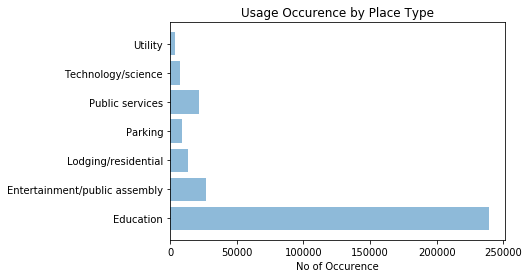

In [56]:
bld_plt = pd.DataFrame()
bld_plt['Primary use'] = primary_use_agg['primary_use']
bld_plt['No of Occurence'] = primary_use_agg['building_id-size']

plt.barh(bld_plt['Primary use'], bld_plt['No of Occurence'], align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.xlabel('No of Occurence')
plt.title('Usage Occurence by Place Type')

plt.show()

In [53]:
bld_plt

,Primary use,No of Occurence
0,Education,239233
1,Entertainment/public assembly,27139
2,Lodging/residential,13085
3,Parking,9111
4,Public services,21702
5,Technology/science,7643
6,Utility,3815


In [74]:
primary_use_agg_meter = train_data_df.groupby(['primary_use']).agg({'meter_reading':['count','sum', 'idxmax', 'max']})

In [75]:
primary_use_agg_meter.head()

meter_reading                          \
                                      count           sum    idxmax   
primary_use                                                           
Education                           8165504  3.743959e+10   8907488   
Entertainment/public assembly       2264917  1.073300e+09  13851463   
Food sales and service               114090  3.478696e+07  16968337   
Healthcare                           398527  2.943511e+08  19443375   
Lodging/residential                 2146413  6.003741e+08   5546980   

                                            
                                       max  
primary_use                                 
Education                      21904700.00  
Entertainment/public assembly    880374.00  
Food sales and service             6895.63  
Healthcare                        28189.50  
Lodging/residential               45409.20

In [77]:
primary_use_agg_meter = reshape_agg_variable(primary_use_agg_meter)

In [78]:
primary_use_agg_meter.head()

,meter_reading-count,meter_reading-sum,meter_reading-idxmax,meter_reading-max
primary_use,,,,
Education,8165504,3.743959e+10,8907488,21904700.00
Entertainment/public assembly,2264917,1.073300e+09,13851463,880374.00
Food sales and service,114090,3.478696e+07,16968337,6895.63
Healthcare,398527,2.943511e+08,19443375,28189.50
Lodging/residential,2146413,6.003741e+08,5546980,45409.20


In [84]:
primary_use_agg_meter.index

Index(['Education', 'Entertainment/public assembly', 'Food sales and service',
       'Healthcare', 'Lodging/residential', 'Manufacturing/industrial',
       'Office', 'Other', 'Parking', 'Public services', 'Religious worship',
       'Retail', 'Services', 'Technology/science', 'Utility',
       'Warehouse/storage'],
      dtype='object', name='primary_use')

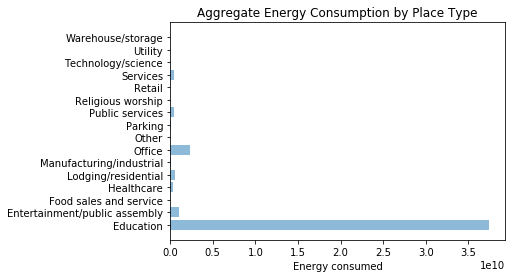

In [86]:
plt.barh(primary_use_agg_meter.index, primary_use_agg_meter['meter_reading-sum'], align='center', alpha=0.5)
plt.xlabel('Energy consumed')
plt.title('Aggregate Energy Consumption by Place Type')
plt.show()

In [34]:
education_meter_reading =  (train_data_df[train_data_df['primary_use']=='Education']).groupby('timestamp')['meter_reading'].mean()

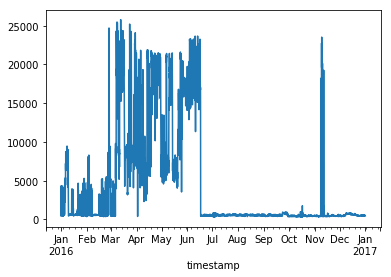

In [35]:
education_meter_reading.plot()

In [88]:
# we can do PCA to see what features are most relevant. lets run XGboost quickly first
train_data_df_m = train_data_df.copy()
train_data_df_m = train_data_df_m.dropna()

In [89]:
train_data_target = train_data_df_m.loc[:,['meter_reading']]
del train_data_df_m['meter_reading'] # that is the target
del train_data_df_m['timestamp']# let drop the time, can be revisited later

In [101]:
# the primary use is better encoded as this is likely to be influential to the prediction
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_data_df_m['primary_use'])
train_data_df_m['primary_use'] = np.uint8(lbl_encoder.transform(train_data_df_m['primary_use']))

In [102]:
train_data_df_m.head(3)

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
3021,565,0,4,0,15326,1954.0,2.0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1
3022,566,0,4,0,2010,1957.0,1.0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1
3023,569,0,4,0,86091,1964.0,8.0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1


In [103]:
x_train, x_val, y_train, y_val = train_test_split(train_data_df_m,train_data_target, test_size =0.3)

In [104]:
dtrain =xgb.DMatrix(x_train,label=y_train)
dval=xgb.DMatrix(x_val, y_val)

param={}
param['max_depth'] = 10 #chnage this to 5 and observe any difference in the testing prediction
param["eta"]=0.03
#param["silent"]=0
param["objective"]='reg:squarederror'

In [105]:
num=1000
xgb_training= xgb.train(param,dtrain,num, verbose_eval = False)

y_pred = xgb_training.predict(dval, ntree_limit=xgb_training.best_ntree_limit, output_margin=True)

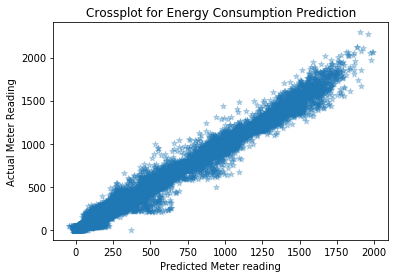

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Crossplot for Energy Consumption Prediction')
ax.set_xlabel('Predicted Meter reading')
ax.set_ylabel('Actual Meter Reading')
ax.scatter(y_pred, y_val, marker='*', alpha=0.3)

In [1]:
from datetime import datetime
today = datetime.today()
train_df.head()

NameError: name 'train_df' is not defined